In [6]:
#找大血管

import cv2
import os
import numpy as np
import matplotlib.pyplot as plt

# 設置圖像目錄
image_dir = r"/home/charlie/projects/entropy/raw/Raw_superficial/reactive/inactive"

# 初始化總面積
results = {}

# 列出目錄中的所有文件
for filename in os.listdir(image_dir):
    # 檢查文件是否為圖像
    if not (filename.endswith(".bmp") or filename.endswith(".jpg")):
        continue

    # 組合文件路徑
    filepath = os.path.join(image_dir, filename)
    
    # 讀取圖像
    img = cv2.imread(filepath, cv2.IMREAD_GRAYSCALE)

    
    #gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    thresh = cv2.threshold(img, 50, 255, cv2.THRESH_BINARY)[1]
    '''
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3,3))
    opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=1)
    '''
    kernel = np.ones((3, 3), np.uint8)
    binary = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel)
    opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel)
    
    cnts = cv2.findContours(opening, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = cnts[0] if len(cnts) == 2 else cnts[1]
    for c in cnts:
        area = cv2.contourArea(c)
        if area < 150:
            cv2.drawContours(opening, [c], -1, (0,0,0), -1)
    
    #cv2.imwrite("/home/charlie/projects/entropy/test/hist/raw/reactive/"+ filename, hist)
    cv2.imwrite("/home/charlie/projects/entropy/test/findlarge/raw/reactive/inactive/"+ filename, opening)

In [24]:
#skeletonize

import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
from skimage import morphology, color

# 設置圖像目錄
image_dir = r"/home/charlie/projects/entropy/preprocessed/otsu/reactive/active"

# 初始化總面積
results = {}

# 列出目錄中的所有文件
for filename in os.listdir(image_dir):
    # 檢查文件是否為圖像
    if not (filename.endswith(".bmp") or filename.endswith(".jpg")):
        continue

    # 組合文件路徑
    filepath = os.path.join(image_dir, filename)
    
    # 讀取圖像
    img = cv2.imread(filepath, cv2.IMREAD_GRAYSCALE)
    img[img == 1] = 0
    img[img >1] = 1
    
    #print(img)
    #img = color.rgb2gray(img)
    #print(img.shape)
    skeleton = morphology.skeletonize(img)
    #print(skeleton)
    skeleton = skeleton.astype('uint8')
    skeleton = skeleton*256
    #img = 1- img
    '''
    #計算直方圖
    histi = cv2.calcHist([img], [0], None, [256], [0, 256])
    #print(hist)
    weight = np.arange(0,256)
    plt.hist(histi.ravel(), 256, [0, 256], color = 'black')
    plt.savefig('/home/charlie/projects/entropy/test/hist/raw/reactive/inactive/'+ filename)
    
    
    sum = 0
    for i in range(256):
        histii = histi[i] * weight[i]
        sum += histii
        
        
    print(filename, sum/(img.shape[0]*img.shape[1]))
    '''
    '''
    skel, distance =morphology.medial_axis(img, return_distance = True)
    dist_on_skel = distance * skel
    dist_on_skel = dist_on_skel.astype(np.uint8)*255
    skel = skel.astype(np.uint8)*255
    distance = distance.astype(np.uint8)*255
    #plt.imshow(skeleton)
    '''
    #cv2.imwrite("/home/charlie/projects/entropy/test/hist/raw/reactive/"+ filename, hist)
    cv2.imwrite("/home/charlie/projects/entropy/test/skeleton/raw/reactive/inactive/"+ filename, skeleton)

In [15]:
import matplotlib
import matplotlib.pyplot as plt
import skimage.io as io
"load image data"
Img_Original =  io.imread( '/home/charlie/projects/entropy/raw/Raw_superficial/reactive/active/6_1054482-8_20170926_OCT_00000256.bmp_superficial.jpg')      # Gray image, rgb images need pre-conversion

"Convert gray images to binary images using Otsu's method"
from skimage.filter import threshold_otsu
Otsu_Threshold = threshold_otsu(Img_Original)   
BW_Original = Img_Original < Otsu_Threshold    # must set object region as 1, background region as 0 !

def neighbours(x,y,image):
    "Return 8-neighbours of image point P1(x,y), in a clockwise order"
    img = image
    x_1, y_1, x1, y1 = x-1, y-1, x+1, y+1
    return [ img[x_1][y], img[x_1][y1], img[x][y1], img[x1][y1],     # P2,P3,P4,P5
                img[x1][y], img[x1][y_1], img[x][y_1], img[x_1][y_1] ]    # P6,P7,P8,P9

def transitions(neighbours):
    "No. of 0,1 patterns (transitions from 0 to 1) in the ordered sequence"
    n = neighbours + neighbours[0:1]      # P2, P3, ... , P8, P9, P2
    return sum( (n1, n2) == (0, 1) for n1, n2 in zip(n, n[1:]) )  # (P2,P3), (P3,P4), ... , (P8,P9), (P9,P2)

def zhangSuen(image):
    "the Zhang-Suen Thinning Algorithm"
    Image_Thinned = image.copy()  # deepcopy to protect the original image
    changing1 = changing2 = 1        #  the points to be removed (set as 0)
    while changing1 or changing2:   #  iterates until no further changes occur in the image
        # Step 1
        changing1 = []
        rows, columns = Image_Thinned.shape               # x for rows, y for columns
        for x in range(1, rows - 1):                     # No. of  rows
            for y in range(1, columns - 1):            # No. of columns
                P2,P3,P4,P5,P6,P7,P8,P9 = n = neighbours(x, y, Image_Thinned)
                if (Image_Thinned[x][y] == 1     and    # Condition 0: Point P1 in the object regions 
                    2 <= sum(n) <= 6   and    # Condition 1: 2<= N(P1) <= 6
                    transitions(n) == 1 and    # Condition 2: S(P1)=1  
                    P2 * P4 * P6 == 0  and    # Condition 3   
                    P4 * P6 * P8 == 0):         # Condition 4
                    changing1.append((x,y))
        for x, y in changing1: 
            Image_Thinned[x][y] = 0
        # Step 2
        changing2 = []
        for x in range(1, rows - 1):
            for y in range(1, columns - 1):
                P2,P3,P4,P5,P6,P7,P8,P9 = n = neighbours(x, y, Image_Thinned)
                if (Image_Thinned[x][y] == 1   and        # Condition 0
                    2 <= sum(n) <= 6  and       # Condition 1
                    transitions(n) == 1 and      # Condition 2
                    P2 * P4 * P8 == 0 and       # Condition 3
                    P2 * P6 * P8 == 0):            # Condition 4
                    changing2.append((x,y))    
        for x, y in changing2: 
            Image_Thinned[x][y] = 0
    return Image_Thinned
 

"Apply the algorithm on images"
BW_Skeleton = zhangSuen(BW_Original)
# BW_Skeleton = BW_Original
"Display the results"
fig, ax = plt.subplots(1, 2)
ax1, ax2 = ax.ravel()
ax1.imshow(BW_Original, cmap=plt.cm.gray)
ax1.set_title('Original binary image')
ax1.axis('off')
ax2.imshow(BW_Skeleton, cmap=plt.cm.gray)
ax2.set_title('Skeleton of the image')
ax2.axis('off')
plt.show()

ModuleNotFoundError: No module named 'skimage.filter'

In [14]:
pip install skimage

  Preparing metadata (setup.py) ... error
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> [3 lines of output]
      
      *** Please install the `scikit-image` package (instead of `skimage`) ***
      
      [end of output]
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.
Note: you may need to restart the kernel to use updated packages.


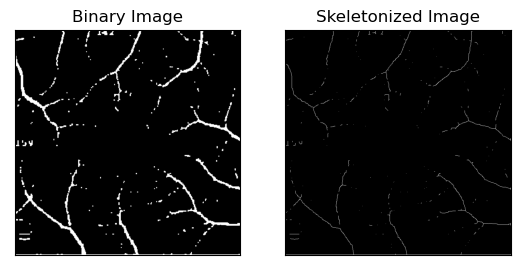

In [3]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import cv2.ximgproc as ximgproc

# Load the image
img = cv2.imread("/home/charlie/projects/entropy/raw/Raw_superficial/reactive/active/6_1054482-8_20170926_OCT_00000256.bmp_superficial.jpg", 0)

# Binarize the image
_, binary = cv2.threshold(img, 128, 255, cv2.THRESH_BINARY)

# Perform morphological operations to remove small objects or holes
kernel = np.ones((3, 3), np.uint8)
binary = cv2.morphologyEx(binary, cv2.MORPH_CLOSE, kernel)
binary = cv2.morphologyEx(binary, cv2.MORPH_OPEN, kernel)

# Skeletonize the binary image
skeleton = ximgproc.thinning(binary)

# Show the original and skeletonized images
plt.subplot(121), plt.imshow(binary, cmap="gray")
plt.title("Binary Image"), plt.xticks([]), plt.yticks([])
plt.subplot(122), plt.imshow(skeleton, cmap="gray")
plt.title("Skeletonized Image"), plt.xticks([]), plt.yticks([])
plt.show()

In [26]:
pip install opencv-contrib-python

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.9/67.9 MB 8.8 MB/s eta 0:00:00:00:0100:01
Note: you may need to restart the kernel to use updated packages.
